# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

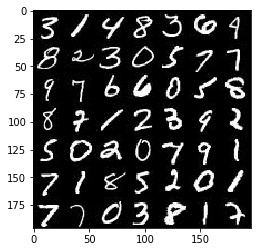

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

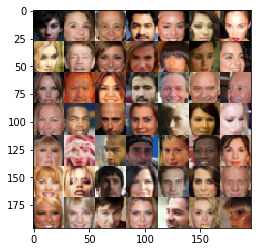

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Shapes
    #
    #    images:  28, 28,   3
    #    relu1 :  14, 14,  64
    #    relu2 :   7,  7, 128
    #    relu3 :   4,  4, 256
    #    flat  :         4096
    
    # TODO: Implement Function    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
    
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Shapes
    #
    #    x1 :   4,  4, 512
    #    x2 :   7,  7, 256
    #    x3 :  14, 14, 128
    #    out:  28, 28,   5    

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss =      tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.9817... Generator Loss: 0.0221
Epoch 1/2... Discriminator Loss: 2.9853... Generator Loss: 0.0643
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.3094
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.2767
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.3242


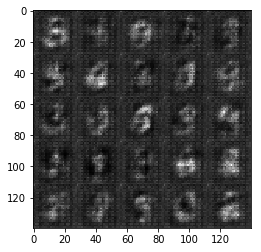

Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.3552
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.3512
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.5131


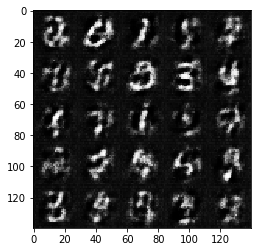

Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.5467


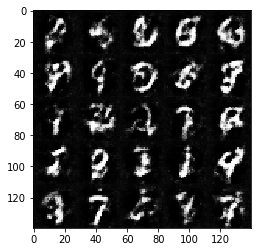

Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.3855
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.3380
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.3856


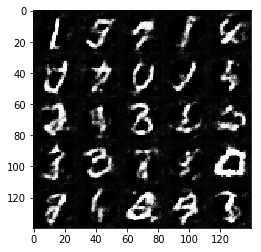

Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 1.4617
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 1.5913
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 1.0405


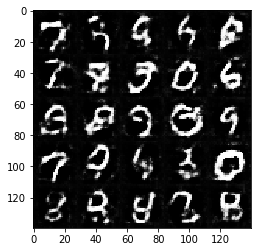

Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 2.3183... Generator Loss: 2.3991
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.6123


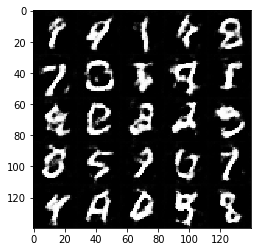

Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.2489
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 2.2265... Generator Loss: 2.3328


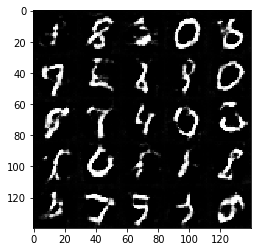

Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 1.6301... Generator Loss: 0.2731
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.7788


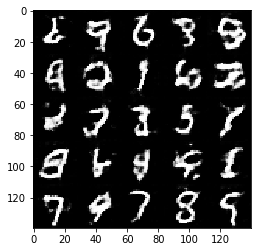

Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.3797
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 1.6807
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 0.7375


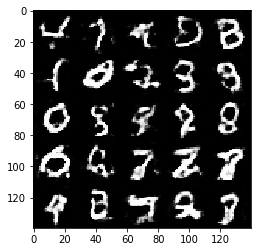

Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.2951
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 0.8234
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 1.5696
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 1.7233
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.8215


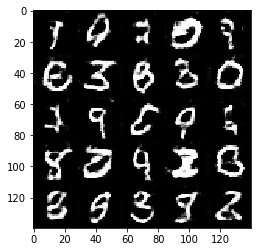

Epoch 2/2... Discriminator Loss: 2.5587... Generator Loss: 0.1120
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 2.2002... Generator Loss: 0.1778
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.5890
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.4402


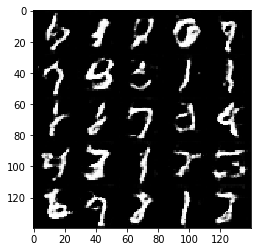

Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 1.8800
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.3083
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.4829


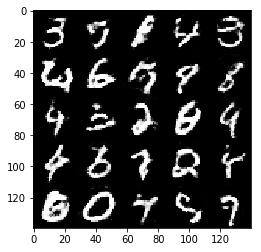

Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 2.3731... Generator Loss: 0.1406
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.3371
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 0.7415


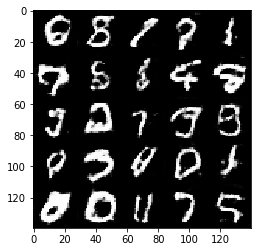

Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 1.3982
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.8685
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 1.9303
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 0.7972


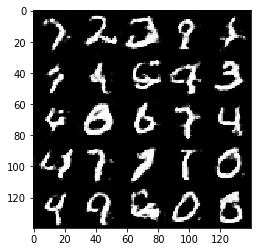

Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 2.3981
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.2643


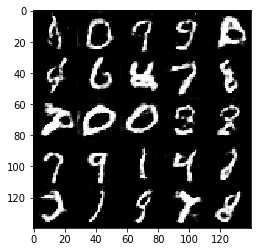

Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 2.5821
Epoch 2/2... Discriminator Loss: 0.7360... Generator Loss: 2.0751
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 1.0179


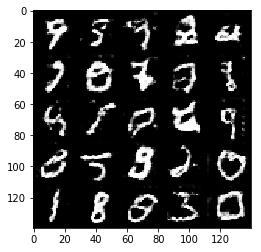

Epoch 2/2... Discriminator Loss: 2.6125... Generator Loss: 0.1138
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.5400
Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 0.6880


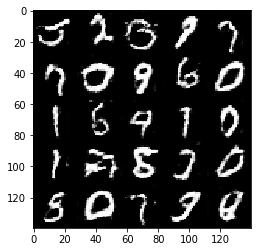

Epoch 2/2... Discriminator Loss: 0.2639... Generator Loss: 2.0756
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 0.8531
Epoch 2/2... Discriminator Loss: 1.9923... Generator Loss: 0.2500


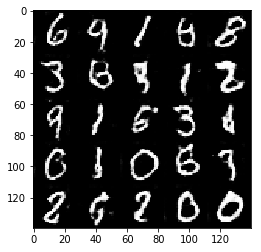

Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 1.5828
Epoch 2/2... Discriminator Loss: 3.0137... Generator Loss: 0.0919
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 0.8117


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1403... Generator Loss: 3.1746
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 2.1119
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 11.4734
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 6.5371
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 4.8737


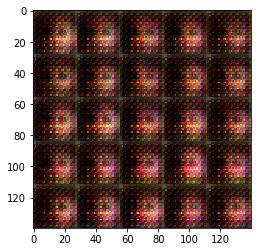

Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 4.2003
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 2.1524
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 3.0498
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 1.9230


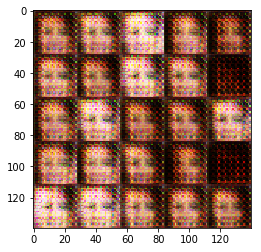

Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 4.0885
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 3.5451
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.6113


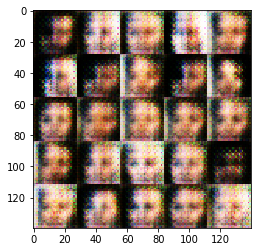

Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0528


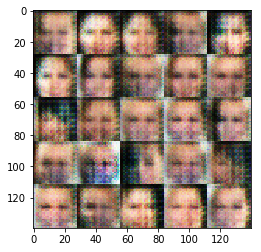

Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.2947


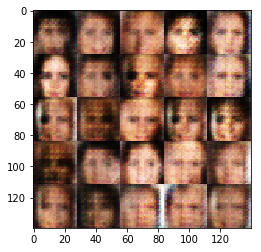

Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.8520
Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 2.3914


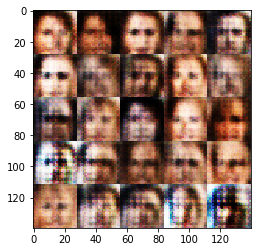

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.5877


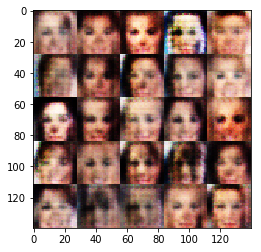

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.6121
Epoch 1/1... Discriminator Loss: 2.3585... Generator Loss: 3.1713
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.0455


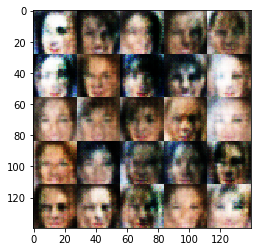

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.9148


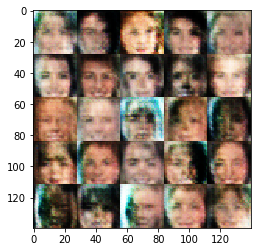

Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.6760


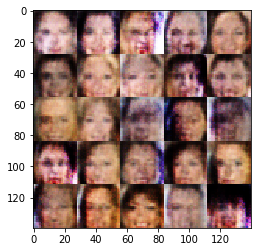

Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 2.7690


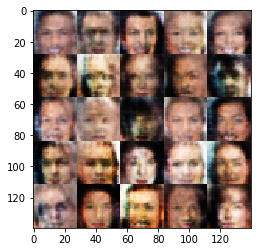

Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.3832
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.2694


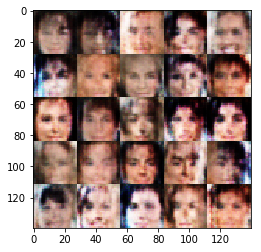

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 3.2450
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 0.8968


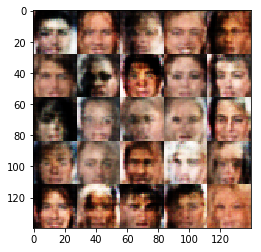

Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7987


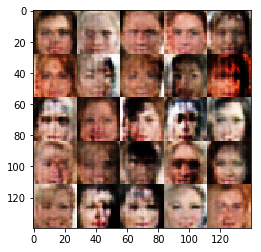

Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 2.0799
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 3.0311


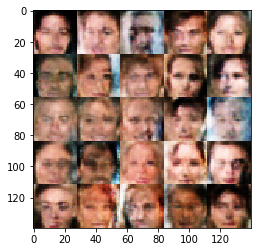

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 2.0612... Generator Loss: 2.4770


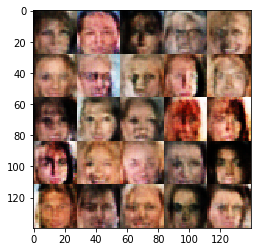

Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.7627
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 3.6024
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.6745
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.6046


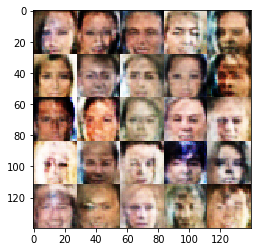

Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.2391... Generator Loss: 2.2317
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 1.6637
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 3.2469
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 1.8654


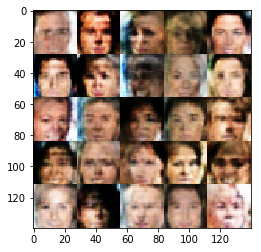

Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 5.2651
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.3686


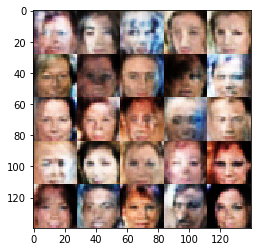

Epoch 1/1... Discriminator Loss: 0.3035... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.1452... Generator Loss: 3.9282
Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 3.0648


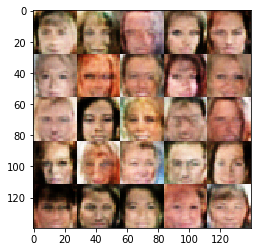

Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 3.5440
Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 2.4677
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 4.2064
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.5299


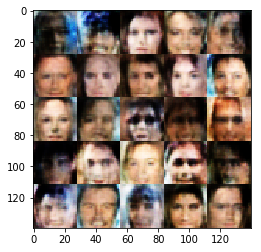

Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.8599
Epoch 1/1... Discriminator Loss: 0.2680... Generator Loss: 3.9060
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.5999


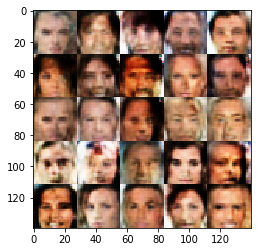

Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 2.3251
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 3.5692
Epoch 1/1... Discriminator Loss: 0.2270... Generator Loss: 3.1342
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 1.7636


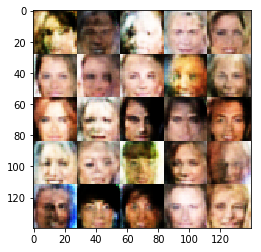

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 4.0530
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 2.8421
Epoch 1/1... Discriminator Loss: 0.1640... Generator Loss: 2.6782
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 1.1730


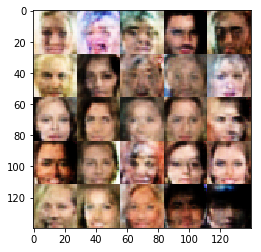

Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 3.7598
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.3557
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.7283


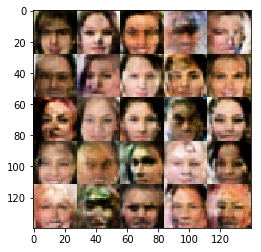

Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 2.5517
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.2219... Generator Loss: 3.4376
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.4986


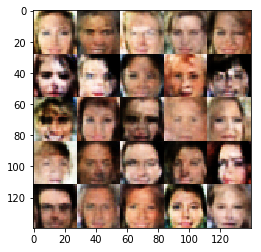

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 1.9960
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 2.0514
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 3.5518


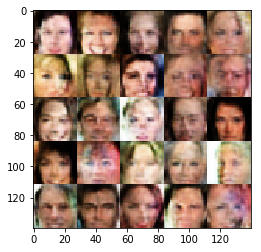

Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 3.6320
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 2.3048
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 0.2174... Generator Loss: 2.4285


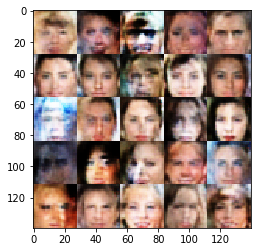

Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 3.2743
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 2.4375
Epoch 1/1... Discriminator Loss: 0.1708... Generator Loss: 2.4003
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 5.5482
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.2536


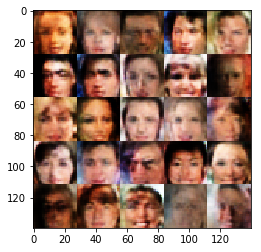

Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 1.7635
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 2.7877
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 4.9080
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 1.7825


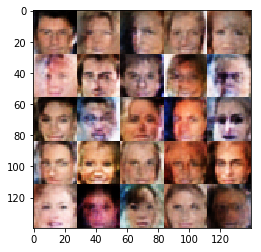

Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.8868
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 3.8599
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 3.6005
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 2.2845


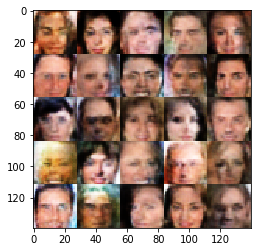

Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.2874


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.